# Pre-processing of Raw Data

In [ ]:
import re
import pandas as pd
import csv
import numpy as np
from sklearn.model_selection import train_test_split
#!pip install emoji
#import emoji as emoji
import keras
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
!pip install transformers
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 596 kB 38.5 MB/s 
     |████████████████████████████████| 101 kB 7.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Add relevant file path

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive/')
PATH_TO_FOLDER = "/content/drive/MyDrive/Colab Notebooks/msc_project/"
import sys
sys.path.append(PATH_TO_FOLDER)
TRAIN_PATH = PATH_TO_FOLDER + 'EXIST2021_training.tsv'
TEST_PATH = PATH_TO_FOLDER + 'EXIST2021_test_labeled.tsv'

Mounted at /content/drive/


create label to ID mapping dict

In [ ]:
#task 1 binary label map word to ID 
labelToID1 = {"non-sexist":0, "sexist":1}

#task 2 multi-class label map word to ID using one-hot vector representation
#labeltoID2 = {"non-sexist":0, "ideological-inequality":1, "stereotyping-dominance":2, "objectification":3, "sexual-violence":4, "misogyny-non-sexual-violence":5}
labeltoID2 = {"non-sexist":[0,0,0,0,0,1], "ideological-inequality":[0,0,0,0,1,0], "stereotyping-dominance":[0,0,0,1,0,0], "objectification":[0,0,1,0,0,0], "sexual-violence":[0,1,0,0,0,0], "misogyny-non-sexual-violence":[1,0,0,0,0,0]}

load the data

In [ ]:
#load the data and return twitter content, task1 & task2 labels
def read_dataset(filepath):
  x = [] #twitter content
  y1= [] #task1 label
  y2= [] #task2 label
  with open(filepath) as fd:
    data = csv.reader(fd, delimiter="\t", quotechar='"')
    for line in data:
      if line[3] == 'en':
        x.append([line[4]])
        y1.append(labelToID1[line[5]])
        y2.append(labeltoID2[line[6]])
  return x, y1, y2

Datasets:
* x_train: the raw 'x data' the twitter content for training and validating use
* y_train1: true labels for task1 for training and validating use
* y_train2: true labels for task2 for training and validating use

* x_test: the raw 'x data' the twitter content for test use
* y_test1: true labels for task1 for test use
* y_test2: true labels for task2 for test use

In [ ]:
x_train, y_train1, y_train2 = read_dataset(TRAIN_PATH)

In [ ]:
x_test, y_test1, y_test2 = read_dataset(TEST_PATH)

In [ ]:
print('number of training twitters:', len(x_train))
print('number of training labels for task1:', len(y_train1))
print('number of training labels for task2:', len(y_train2))
print('the first 5 training twitters are:', x_train[0:5])
print('task1 label for the first 5 training twitters are:', y_train1[0:5])
print('task2 label for the first 5 training twitters are:', y_train2[0:5])

number of training twitters: 3436
number of training labels for task1: 3436
number of training labels for task2: 3436
the first 5 training twitters are: [['She calls herself "anti-feminazi" how about shut the fucking up on your vile commentary on an elderly responsible citizen tu sach muuch ghani baawri-bewdi hai bey https://t.co/ZMxTDwsY5D'], ['Now, back to these women, the brave and the beautiful, @Clare_Crawley and @tayshia. These bad ass babes, are deserve so much credit for how this season has gone. As a woman, I’ve learned so much from them and feel more empowered to expect more in future relationships.'], ["@CurvyBandida @Xalynne_B Wow, your skirt is very short. What is it's length? 5 inch or more?"], ['@AurelieGuiboud Incredible!  Beautiful!But I laughed so much when I read about you drifting in your wheelchair.I can just picture it  https://t.co/uvl5HhbmbR'], ['i find it extremely hard to believe that kelly or a 66 yr old mum would believe any of this, so it makes me question 

In [ ]:
print('number of testing twitters:', len(x_test))
print('number of testing labels for task1:', len(y_test1))
print('number of testing labels for task2:', len(y_test2))
print('the first 5 testing twitters is:', x_test[0:5])
print('task1 label for the first 5 testing twitters is:', y_test1[0:5])
print('task2 label for the first 5 testing twitters is:', y_test2[0:5])

number of testing twitters: 2208
number of testing labels for task1: 2208
number of testing labels for task2: 2208
the first 5 testing twitters is: [["Pennsylvania State Rep horrifies with opening prayermooslime politican Movita Johnson-Harrell offended by the word 'Jesus' and 'God'.In a mainly Christian country praying to God/Jesus - what a scandal /sarc. It's the well-known mooslime strategy: playing the victim card and make demands.https://truepundit.com/pennsylvania-state-rep-horrifies-democrats-with-opening-prayer-at-the-name-of-jesus-every-knee-will-bow/"], ['@iilovegrapes He sounds like as ass, and very condescending.'], ['@averyangryskel1 @4ARealistParty LOL! "This behavior of not letting men tell you women what feminism is and redefine it to center us is EXACTLY why you gals don\'t get taken seriously!"You are sad. So sad.'], ["@WanderOrange @stalliontwink Rights?I mean yeah most women especially the women in african and middle east region are discriminatedBut what basic human

In [ ]:
#corpus = [["abc."],["@apple He is"],['http://www.google.com xxx :) #"I’ve I\'M']]

In [ ]:
def pre_process_dataset(corpus):
  # Emoticons
  emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

  newcorpus = []
  for sent in corpus:
    newsent = [text.lower() for text in sent]
    for text in newsent:
      users = re.findall("[@]\w+", text)
      #print(users)
    
    #replace all '@user' to '<user>'
    for user in users:
      newsent = [text.replace(user, " <user> ") for text in newsent]

    #replace urls to '<url>'
    urls = re.findall(r'(https?://[^\s]+)', text)
    for url in urls:
      newsent = [text.replace(url, " <url> ") for text in newsent]
    
    #for emo in emoji.UNICODE_EMOJI:
      #newsent = [text.replace(emo, " <emotion> ") for text in newsent]
    
    #replace all emotions with '<emotion>'
    for emo in emoticons:
      newsent = [text.replace(emo, " <emotion> ") for text in newsent]
    
    #replace all # to <hashtag>
    newsent = [text.replace('#', " <hashtag> ") for text in newsent]
    
    #replace '-' with a space
    newsent = [text.replace('-', " ") for text in newsent]
    
    newsent = [text.replace('\xa0', " ") for text in newsent]

    #remove these symbols !*^&()%$,.:;[]{}=~_+?\|/
    symbols = '!*^&()%$,.:;[]{}=~_+?\|/"''‘’“”'
    for symbol in symbols:
      newsent = [text.replace(symbol, "") for text in newsent]
    
    newcorpus.append(newsent)
  return newcorpus

In [ ]:
#pre-processing of the 'x' data
x_train = pre_process_dataset(x_train)
x_test = pre_process_dataset(x_test)

split x_train to training and validation data with ratio 80:20

In [ ]:
#data for task1
#x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train, y_train1, test_size=0.2, random_state=42)

In [ ]:
#data for task2
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train, y_train2, test_size=0.2, random_state=42)

In [ ]:
y_train2 = np.array(y_train2)
y_val2= np.array(y_val2)
y_test2= np.array(y_test2)

In [ ]:
#frequency in each class
for label in labeltoID2.values():
  print(label, y_train2.tolist().count(label), y_val2.tolist().count(label), y_train2.tolist().count(label) + y_val2.tolist().count(label))

[0, 0, 0, 0, 0, 1] 1435 365 1800
[0, 0, 0, 0, 1, 0] 303 83 386
[0, 0, 0, 1, 0, 0] 290 76 366
[0, 0, 1, 0, 0, 0] 213 43 256
[0, 1, 0, 0, 0, 0] 275 69 344
[1, 0, 0, 0, 0, 0] 232 52 284


In [ ]:
#frequency in each class
for label in labeltoID2.values():
  print(label, y_test2.tolist().count(label))

[0, 0, 0, 0, 0, 1] 1050
[0, 0, 0, 0, 1, 0] 333
[0, 0, 0, 1, 0, 0] 262
[0, 0, 1, 0, 0, 0] 150
[0, 1, 0, 0, 0, 0] 198
[1, 0, 0, 0, 0, 0] 215


# More data processing for non-Bert related models

build a vocabulary based on the training dataset

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in x_train2:
  text_tokens = text_to_word_sequence(example[0])
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))  

10867
10871


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the text to word tokens and integers separately:

In [ ]:
def w2i(text):
  tokens = text_to_word_sequence(text)
  idxs = []
  for t in tokens:
    if t not in word_index:
      idxs.append(word_index["<UNK>"])
    else:
      idxs.append(word_index[t])
  return tokens, idxs

def tokenize2(dataset):
  tokens_list = []
  idxs_list = []
  for example in dataset:
    tokens, idxs = w2i(example[0])
    tokens_list.append(tokens)
    idxs_list.append(idxs)

  return tokens_list, idxs_list

x_train2_token, x_train2_int = tokenize2(x_train2)
x_val2_token, x_val2_int = tokenize2(x_val2)
x_test_token, x_test_int = tokenize2(x_test)

#verify and show sample result
assert len(x_train2) == len(x_train2_token)
assert len(x_train2) == len(x_train2_int)
assert len(x_val2) == len(x_val2_token)
assert len(x_val2) == len(x_val2_int)
assert len(x_test) == len(x_test_token)
assert len(x_test) == len(x_test_int) 
print("x_train2_token[0]:")
print(x_train2_token[0])
print("x_train2_int[0]:")
print(x_train2_int[0])


x_train2_token[0]:
['my', 'favorite', 'url']
x_train2_int[0]:
[4055, 9810, 5905]


In [ ]:
MAX_SEQUENCE_LENGTH = 128
x_train2_pad = keras.preprocessing.sequence.pad_sequences(x_train2_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_val2_pad = keras.preprocessing.sequence.pad_sequences(x_val2_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)
x_train2_pad = np.array(x_train2_pad)
x_val2_pad = np.array(x_val2_pad)
x_test_pad = np.array(x_test_pad)
print("Before paded:")
print(x_train2_token[0])
print(x_train2_int[0])
print("After paded:")
print(x_train2_pad[0])

Before paded:
['my', 'favorite', 'url']
[4055, 9810, 5905]
After paded:
[4055 9810 5905    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# More data processing for Bert related models

example for train&val data

In [ ]:
print('number of training twitters:', len(x_train2))
print('number of training labels for task2:', len(y_train2))
print('the first 5 training twitters are:', x_train2[0:5])
print('task2 label for the first 5 training twitters are:', y_train2[0:5])

number of training twitters: 2748
number of training labels for task2: 2748
the first 5 training twitters are: [['my favorite  <url> '], ['eminem im going to chain you up in my basement sodomize you and then pop a xanny to relax while jerking off to disney original childrens showswhite people no rapper alive is touching this mans bars  <url> '], ['jimin manspreading   <url> '], [" <user>  but of course you shouldn't have to perception is however socially conditioned into people so it becomes expectations loads of women of all colours rely on the mother instinct myth to get by esp religious fundamentalism has jacked up white women innate altruism so high"], ['uh uh— k—koo oh my— koos comin comin his other hand harshly cups his crotch hoping to block his little cock from coming but its obviously useless koo cant take it anymore and he abandons himself to the pleasure']]
task2 label for the first 5 training twitters are: [[0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 

example for test data

In [ ]:
print('number of testing twitters:', len(x_test))

print('number of testing labels for task2:', len(y_test2))
print('the first 5 testing twitters is:', x_test[0:5])

print('task2 label for the first 5 testing twitters is:\n', y_test2[0:5])

number of testing twitters: 2208
number of testing labels for task2: 2208
the first 5 testing twitters is: [["pennsylvania state rep horrifies with opening prayermooslime politican movita johnson harrell offended by the word 'jesus' and 'god'in a mainly christian country praying to godjesus   what a scandal sarc it's the well known mooslime strategy playing the victim card and make demands <url> "], [' <user>  he sounds like as ass and very condescending'], [" <user>   <user>  lol this behavior of not letting men tell you women what feminism is and redefine it to center us is exactly why you gals don't get taken seriouslyyou are sad so sad"], [" <user>   <user>  rightsi mean yeah most women especially the women in african and middle east region are discriminatedbut what basic human right do men have that women don'tthanks to feminism"], ['the jack manifold appreciation im seeing is on my tl tonight so beautiful']]
task2 label for the first 5 testing twitters is:
 [[0 0 0 0 0 1]
 [0 0 0

# DistilBert Tokenization

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, and runs 60% faster, while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

In [ ]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        #print(inputs,'end of inputs')
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids']) 
        #print(inputs,'end of inputs')       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
#example testing
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')
#corpus = [["abc."],["@apple He is"],['http://www.google.com xxx :) #"I’ve I\'M']]
ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 



In [ ]:
x_train2_int = [tokenize(x_train2[i[0]][0],tokenizer)[0] for i in enumerate(x_train2)]
x_train2_mask = [tokenize(x_train2[i[0]][0],tokenizer)[1] for i in enumerate(x_train2)]

x_val2_int = [tokenize(x_val2[i[0]][0],tokenizer)[0] for i in enumerate(x_val2)]
x_val2_mask = [tokenize(x_val2[i[0]][0],tokenizer)[1] for i in enumerate(x_val2)]

x_test2_int = [tokenize(x_test[i[0]][0],tokenizer)[0] for i in enumerate(x_test)]
x_test2_mask = [tokenize(x_test[i[0]][0],tokenizer)[1] for i in enumerate(x_test)]

x_train2_int_np = np.array(x_train2_int)
x_train2_mask_np = np.array(x_train2_mask)
x_val2_int_np = np.array(x_val2_int)
x_val2_mask_np = np.array(x_val2_mask)
x_test2_int_np = np.array(x_test2_int)
x_test2_mask_np = np.array(x_test2_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model 0 -baseline

## Model0-1 - NBOW without pre-trained word embeddings

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
VOCAB_SIZE= len(word_index)
EMBED_SIZE=100
hidden_layer=50
MAX_SEQUENCE_LENGTH = 128

input_sent=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32', name='Input')
embedded_sent= Embedding(VOCAB_SIZE, EMBED_SIZE, name='Embedding',
embeddings_initializer='glorot_uniform', input_length=MAX_SEQUENCE_LENGTH)(input_sent)
pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)

hidden_output=Dense(hidden_layer,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),kernel_initializer='glorot_uniform', activation='relu',name='Hidden_1')(pooled_sent)
label=Dense(6,input_shape=(hidden_layer,),activation='softmax',name='Output')(hidden_output)
model0_1 = Model(inputs=input_sent, outputs=[label],name='Model_0_1')
model0_1.summary()
optimizer0 = tf.keras.optimizers.Adam(learning_rate=2e-5)
model0_1.compile(optimizer=optimizer0, loss='binary_crossentropy', metrics=['accuracy'])

history = model0_1.fit(x_train2_pad,
                    y_train2,
                    epochs=30,
                    batch_size=8,
                    validation_data=(x_val2_pad, y_val2),
                    verbose=1)

results = model0_1.evaluate(x_test_pad, y_test2)
print(results)


Model: "Model_0_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128)]             0         
                                                                 
 Embedding (Embedding)       (None, 128, 100)          1087100   
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_6 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 Hidden_1 (Dense)            (None, 50)                5050      
                                                                 
 Output (Dense)              (None, 6)                 306       
                                                                 
Total params: 1,092,456
Trainable params: 1,092,456
Non-t

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       215
           1     0.0000    0.0000    0.0000       198
           2     0.0000    0.0000    0.0000       150
           3     0.0000    0.0000    0.0000       262
           4     0.0000    0.0000    0.0000       333
           5     0.4755    1.0000    0.6446      1050

    accuracy                         0.4755      2208
   macro avg     0.0793    0.1667    0.1074      2208
weighted avg     0.2261    0.4755    0.3065      2208



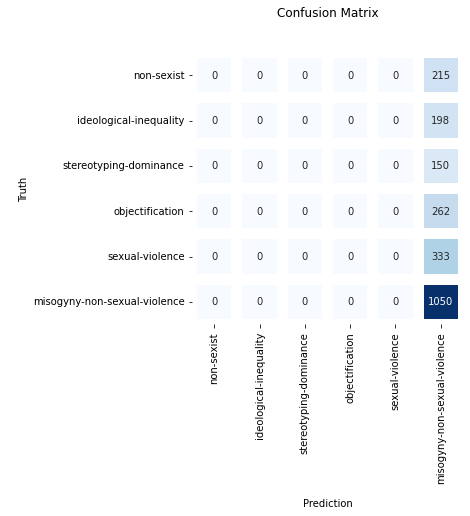

In [ ]:
y_pred01 = model0_1.predict(x_test_pad)
from sklearn.metrics import classification_report, accuracy_score
y_pred01_bool = np.argmax(y_pred01, axis=1)
print(classification_report(np.argmax(y_test2,axis=1), y_pred01_bool, digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2,axis=1), y_pred01_bool)
fig, ax = plt.subplots(figsize=(5,5))

plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

## Model0-2 - NBOW using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-08-08 13:35:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-08 13:35:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-08 13:35:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

We freeze the weights. To create the model:

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### model

In [ ]:
hdepth=50
MAX_SEQUENCE_LENGTH = 128

input_sent=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedded_sent= embeddingLayer(input_sent)
pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='relu',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
label=Dense(6,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
model02 = Model(inputs=input_sent, outputs=[label],name='Model_0-2')
model02.summary()

Model: "Model_0-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_7 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 50)                15050     
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                         

In [ ]:
optimizer0 = tf.keras.optimizers.Adam(learning_rate=2e-5)
model02.compile(optimizer=optimizer0, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model02.fit(x_train2_pad,
                    y_train2,
                    epochs=30,
                    batch_size=8,
                    validation_data=(x_val2_pad, y_val2),
                    verbose=1)

Epoch 1/30
344/344 [==============================] - 2s 5ms/step - loss: 0.6705 - accuracy: 0.1161 - val_loss: 0.6607 - val_accuracy: 0.1221
Epoch 2/30
344/344 [==============================] - 2s 6ms/step - loss: 0.6360 - accuracy: 0.1550 - val_loss: 0.6241 - val_accuracy: 0.1875
Epoch 3/30
344/344 [==============================] - 2s 5ms/step - loss: 0.5957 - accuracy: 0.4192 - val_loss: 0.5854 - val_accuracy: 0.4360
Epoch 4/30
344/344 [==============================] - 1s 4ms/step - loss: 0.5590 - accuracy: 0.5222 - val_loss: 0.5512 - val_accuracy: 0.5262
Epoch 5/30
344/344 [==============================] - 1s 4ms/step - loss: 0.5275 - accuracy: 0.5222 - val_loss: 0.5216 - val_accuracy: 0.5305
Epoch 6/30
344/344 [==============================] - 1s 4ms/step - loss: 0.4994 - accuracy: 0.5222 - val_loss: 0.4946 - val_accuracy: 0.5305
Epoch 7/30
344/344 [==============================] - 2s 4ms/step - loss: 0.4770 - accuracy: 0.5222 - val_loss: 0.4741 - val_accuracy: 0.5305
Epoch 

In [ ]:
y_pred02 = model02.predict(x_test_pad)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       215
           1     0.0000    0.0000    0.0000       198
           2     0.0000    0.0000    0.0000       150
           3     0.0000    0.0000    0.0000       262
           4     0.0000    0.0000    0.0000       333
           5     0.4755    1.0000    0.6446      1050

    accuracy                         0.4755      2208
   macro avg     0.0793    0.1667    0.1074      2208
weighted avg     0.2261    0.4755    0.3065      2208



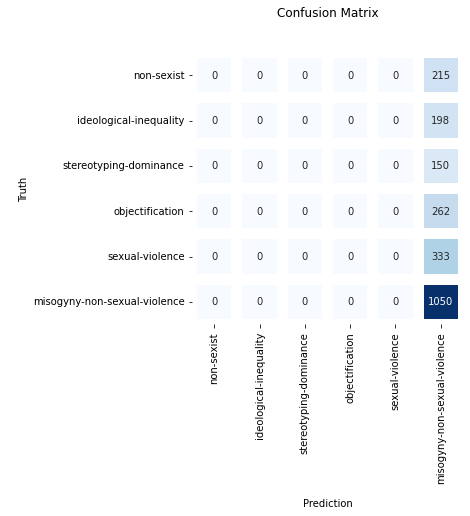

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred02_bool = np.argmax(y_pred02, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred02_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred02_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

In [ ]:
a = np.argmax(y_test2, axis=1)
np.count_nonzero(a == 5)

1050

# Model1 - DistilBERT sequence classification

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=6)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 6),                                                 
                                 hidden_states=None                                           

In [ ]:
history = model.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 18s 53ms/step - loss: 2.2421 - accuracy: 0.5222 - val_loss: 2.1821 - val_accuracy: 0.5305
Epoch 2/10
344/344 [==============================] - 17s 49ms/step - loss: 2.2316 - accuracy: 0.5222 - val_loss: 2.1767 - val_accuracy: 0.5305
Epoch 3/10
344/344 [==============================] - 17s 49ms/step - loss: 2.2283 - accuracy: 0.5222 - val_loss: 2.1747 - val_accuracy: 0.5305
Epoch 4/10
344/344 [==============================] - 17s 50ms/step - loss: 2.2237 - accuracy: 0.5222 - val_loss: 2.1813 - val_accuracy: 0.5305
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 2.2165 - accuracy: 0.5222 - val_loss: 2.1741 - val_accuracy: 0.5305
Epoch 6/10
344/344 [==============================] - 18s 51ms/step - loss: 1.0439 - accuracy: 0.5175 - val_loss: 0.9215 - val_accuracy: 0.5480
Epoch 7/10
344/344 [==============================] - 18s 51ms/step - loss: 0.8817 - accuracy: 0.6117 - val_loss: 1.0504 - val_accuracy:

In [ ]:
#results = model.evaluate([x_test1_int_np,x_test1_mask_np], y_test1, batch_size=512)
#print(results)

In [ ]:
y_pred = model.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.3333    0.2419    0.2803       215
           1     0.3921    0.4495    0.4188       198
           2     0.4722    0.2267    0.3063       150
           3     0.3854    0.4427    0.4121       262
           4     0.5497    0.5646    0.5570       333
           5     0.6811    0.7200    0.7000      1050

    accuracy                         0.5593      2208
   macro avg     0.4690    0.4409    0.4458      2208
weighted avg     0.5522    0.5593    0.5514      2208



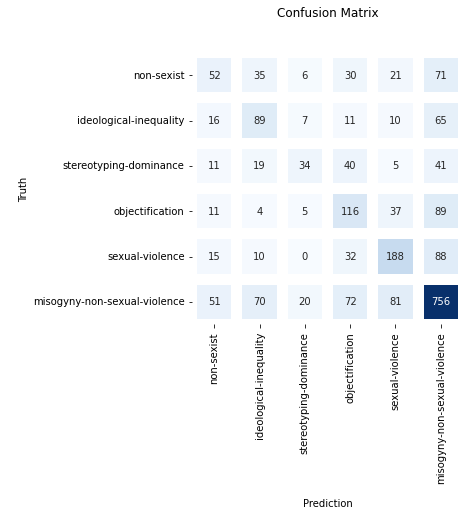

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_bool = np.argmax(y_pred.logits, axis=1)
#y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model2 - DistilBERT+NBOW

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=50
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='relu',kernel_initializer='glorot_uniform')(pooled_sent) # relu
  label=Dense(6,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(learning_rate = 5e-5)
    model2.compile(optimizer=optimizer2, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.56.92.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.92.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

In [ ]:
model2.summary() 

Model: "Model2_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:
history = model2.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 20s 59ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 2.5410 - val_accuracy: 0.5901
Epoch 2/10
344/344 [==============================] - 18s 53ms/step - loss: 0.0349 - accuracy: 0.9876 - val_loss: 2.7540 - val_accuracy: 0.6090
Epoch 3/10
344/344 [==============================] - 18s 53ms/step - loss: 0.0341 - accuracy: 0.9902 - val_loss: 2.2812 - val_accuracy: 0.5887
Epoch 4/10
344/344 [==============================] - 20s 59ms/step - loss: 0.0363 - accuracy: 0.9905 - val_loss: 2.0329 - val_accuracy: 0.6148
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 2.2342 - val_accuracy: 0.5741
Epoch 6/10
344/344 [==============================] - 17s 50ms/step - loss: 0.0374 - accuracy: 0.9869 - val_loss: 2.3249 - val_accuracy: 0.5959
Epoch 7/10
344/344 [==============================] - 17s 50ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 2.6186 - val_accuracy:

In [ ]:
y_pred2 = model2.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.3355    0.4698    0.3915       215
           1     0.4967    0.3788    0.4298       198
           2     0.4909    0.3600    0.4154       150
           3     0.3971    0.4198    0.4082       262
           4     0.5619    0.5586    0.5602       333
           5     0.6908    0.6829    0.6868      1050

    accuracy                         0.5630      2208
   macro avg     0.4955    0.4783    0.4820      2208
weighted avg     0.5709    0.5630    0.5644      2208



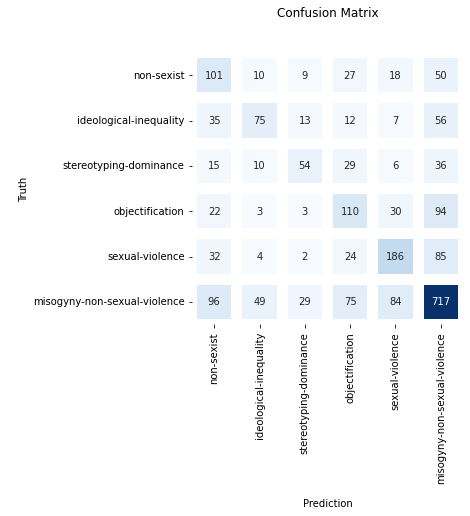

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred2_bool = np.argmax(y_pred2.logits, axis=1)
y_pred2_bool = np.argmax(y_pred2, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred2_bool, digits=4))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred2_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

In [ ]:
history = model2.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/30
6/6 [==============================] - 102s 9s/step - loss: 1.5626 - accuracy: 0.4538 - val_loss: 1.3826 - val_accuracy: 0.5305
Epoch 2/30
6/6 [==============================] - 2s 310ms/step - loss: 1.4028 - accuracy: 0.5222 - val_loss: 1.2960 - val_accuracy: 0.5320
Epoch 3/30
6/6 [==============================] - 2s 312ms/step - loss: 1.2645 - accuracy: 0.5349 - val_loss: 1.1467 - val_accuracy: 0.5814
Epoch 4/30
6/6 [==============================] - 2s 315ms/step - loss: 1.0975 - accuracy: 0.5953 - val_loss: 1.0689 - val_accuracy: 0.5712
Epoch 5/30
6/6 [==============================] - 2s 312ms/step - loss: 0.9558 - accuracy: 0.6459 - val_loss: 0.9531 - val_accuracy: 0.6453
Epoch 6/30
6/6 [==============================] - 2s 312ms/step - loss: 0.8274 - accuracy: 0.6914 - val_loss: 0.9328 - val_accuracy: 0.6468
Epoch 7/30
6/6 [==============================] - 2s 313ms/step - loss: 0.7401 - accuracy: 0.7271 - val_loss: 0.9107 - val_accuracy: 0.6846
Epoch 8/30
6/6 [=====

In [ ]:
y_pred2 = model2.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0       0.35      0.43      0.39       215
           1       0.51      0.46      0.48       198
           2       0.47      0.37      0.41       150
           3       0.44      0.44      0.44       262
           4       0.64      0.52      0.58       333
           5       0.71      0.75      0.73      1050

    accuracy                           0.60      2208
   macro avg       0.52      0.50      0.51      2208
weighted avg       0.60      0.60      0.60      2208



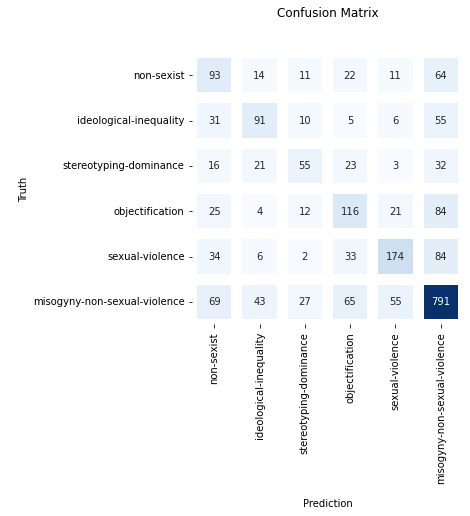

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred2_bool = np.argmax(y_pred2.logits, axis=1)
y_pred2_bool = np.argmax(y_pred2, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred2_bool))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred2_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

In [ ]:
y_pred2[0:4]

array([[0.13199544],
       [0.13272032],
       [0.94434655],
       [0.94384617]], dtype=float32)

In [ ]:
y_pred2_bool[0:4]

array([[0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = np.argmax(y_pred2, axis=1)
print(classification_report(y_test1, y_pred2_bool))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1050
           1       0.73      0.77      0.75      1158

    accuracy                           0.73      2208
   macro avg       0.73      0.73      0.73      2208
weighted avg       0.73      0.73      0.73      2208



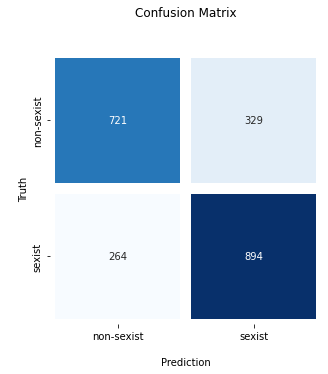

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred2_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model3 - DistilBERT + LSTM 

In [ ]:
# your code goes here
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def lstm():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  LSTM_sent=LSTM(100,name='LSTM')(embedded_sent)                             # LSTM
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='relu',kernel_initializer='glorot_uniform',name='Hidden_1')(LSTM_sent)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  #label=Dense(3,input_shape=(EMBED_SIZE,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(LSTM_sent)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model3_LSTM')


use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model3 = lstm()
    optimizer3 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model3.compile(optimizer=optimizer3, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model3 = lstm()
  model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary() 


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model3_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:
history = model3.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 80s 74ms/step - loss: 1.2947 - accuracy: 0.5531 - val_loss: 1.0697 - val_accuracy: 0.6221
Epoch 2/10
344/344 [==============================] - 21s 62ms/step - loss: 0.9788 - accuracy: 0.6507 - val_loss: 0.9299 - val_accuracy: 0.6555
Epoch 3/10
344/344 [==============================] - 21s 62ms/step - loss: 0.7740 - accuracy: 0.7234 - val_loss: 0.9215 - val_accuracy: 0.6570
Epoch 4/10
344/344 [==============================] - 21s 62ms/step - loss: 0.6091 - accuracy: 0.7969 - val_loss: 0.9650 - val_accuracy: 0.6453
Epoch 5/10
344/344 [==============================] - 21s 62ms/step - loss: 0.4190 - accuracy: 0.8657 - val_loss: 1.0350 - val_accuracy: 0.6657
Epoch 6/10
344/344 [==============================] - 21s 61ms/step - loss: 0.3125 - accuracy: 0.9098 - val_loss: 1.1096 - val_accuracy: 0.6512
Epoch 7/10
344/344 [==============================] - 21s 62ms/step - loss: 0.2496 - accuracy: 0.9225 - val_loss: 1.1340 - val_accuracy:

In [ ]:
y_pred3 = model3.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.4236    0.2837    0.3398       215
           1     0.4611    0.3889    0.4219       198
           2     0.4069    0.3933    0.4000       150
           3     0.5023    0.4122    0.4528       262
           4     0.6478    0.4805    0.5517       333
           5     0.6620    0.8133    0.7299      1050

    accuracy                         0.5974      2208
   macro avg     0.5173    0.4620    0.4827      2208
weighted avg     0.5824    0.5974    0.5821      2208



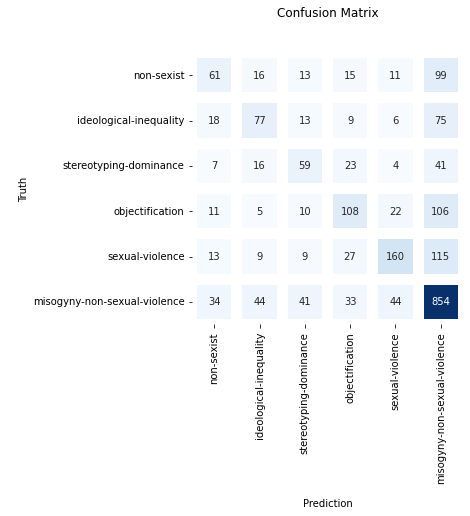

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred3_bool = np.argmax(y_pred3, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred3_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred3_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred3_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model4 - DistilBERT + single CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def cnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  CNN_sent=Conv1D(filters=100,
                 kernel_size=6,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1D')(embedded_sent)                             # CNN
  pooled_sent=GlobalMaxPooling1D(name='MaxPool')(CNN_sent)
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(pooled_sent)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model4_CNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model4 = cnn()
    optimizer4 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model4.compile(optimizer=optimizer4, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model4 = cnn()
  model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model4_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                      

In [ ]:
history = model4.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 84s 62ms/step - loss: 1.3431 - accuracy: 0.5277 - val_loss: 1.0897 - val_accuracy: 0.6076
Epoch 2/10
344/344 [==============================] - 17s 49ms/step - loss: 1.0213 - accuracy: 0.6343 - val_loss: 0.9890 - val_accuracy: 0.6555
Epoch 3/10
344/344 [==============================] - 18s 51ms/step - loss: 0.8235 - accuracy: 0.7289 - val_loss: 0.9755 - val_accuracy: 0.6526
Epoch 4/10
344/344 [==============================] - 17s 50ms/step - loss: 0.6684 - accuracy: 0.7882 - val_loss: 0.9622 - val_accuracy: 0.6788
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.4994 - accuracy: 0.8646 - val_loss: 1.0129 - val_accuracy: 0.6599
Epoch 6/10
344/344 [==============================] - 17s 49ms/step - loss: 0.4039 - accuracy: 0.8934 - val_loss: 1.0498 - val_accuracy: 0.6512
Epoch 7/10
344/344 [==============================] - 17s 50ms/step - loss: 0.3067 - accuracy: 0.9272 - val_loss: 1.1634 - val_accuracy:

In [ ]:
y_pred4 = model4.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.3415    0.3256    0.3333       215
           1     0.4531    0.4394    0.4462       198
           2     0.4722    0.4533    0.4626       150
           3     0.6146    0.2252    0.3296       262
           4     0.5266    0.6246    0.5714       333
           5     0.6828    0.7648    0.7215      1050

    accuracy                         0.5865      2208
   macro avg     0.5151    0.4721    0.4774      2208
weighted avg     0.5830    0.5865    0.5723      2208



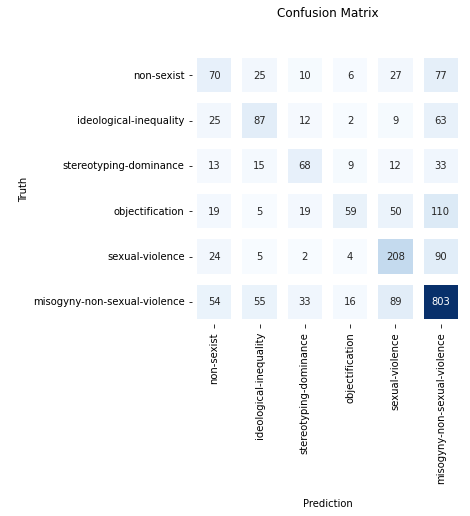

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred4_bool = np.argmax(y_pred4, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred4_bool,digits=4))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred4_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model5 - DistilBERT + multi CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
from keras.layers import Concatenate
EMBED_SIZE = 100
hidden_layer = 50

def multicnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  
  conv_blocks = []
  CNN_sent1=Conv1D(filters=100,
                 kernel_size=3,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1')(embedded_sent)                             # CNN1
  pooled_sent1=GlobalMaxPooling1D(name='MaxPool1')(CNN_sent1)  
  CNN_sent2=Conv1D(filters=100,
                 kernel_size=5,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN2')(embedded_sent)                             # CNN2
  pooled_sent2=GlobalMaxPooling1D(name='MaxPool2')(CNN_sent2)
  CNN_sent3=Conv1D(filters=100,
                 kernel_size=7,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN3')(embedded_sent)                             # CNN3
  pooled_sent3=GlobalMaxPooling1D(name='MaxPool3')(CNN_sent3)
  conv_blocks.append(pooled_sent1)
  conv_blocks.append(pooled_sent2)
  conv_blocks.append(pooled_sent3)

  #merge
  combined = Concatenate()(conv_blocks)

  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(combined)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model5_multiCNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model5 = multicnn()
    optimizer5 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model5.compile(optimizer=optimizer5, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model5 = multicnn()
  model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model5_multiCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                 

In [ ]:
history = model5.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 77s 63ms/step - loss: 1.3023 - accuracy: 0.5484 - val_loss: 1.0781 - val_accuracy: 0.6090
Epoch 2/10
344/344 [==============================] - 18s 51ms/step - loss: 0.9730 - accuracy: 0.6623 - val_loss: 0.9297 - val_accuracy: 0.6686
Epoch 3/10
344/344 [==============================] - 17s 49ms/step - loss: 0.7499 - accuracy: 0.7438 - val_loss: 0.9051 - val_accuracy: 0.6817
Epoch 4/10
344/344 [==============================] - 17s 50ms/step - loss: 0.5691 - accuracy: 0.8242 - val_loss: 0.9370 - val_accuracy: 0.6715
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.4174 - accuracy: 0.8861 - val_loss: 0.9577 - val_accuracy: 0.6773
Epoch 6/10
344/344 [==============================] - 17s 51ms/step - loss: 0.3323 - accuracy: 0.9214 - val_loss: 0.9690 - val_accuracy: 0.6642
Epoch 7/10
344/344 [==============================] - 17s 51ms/step - loss: 0.2446 - accuracy: 0.9487 - val_loss: 1.0166 - val_accuracy:

In [ ]:
y_pred5 = model5.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.3494    0.4047    0.3750       215
           1     0.4605    0.5303    0.4930       198
           2     0.3450    0.5933    0.4363       150
           3     0.4921    0.4733    0.4825       262
           4     0.6975    0.4985    0.5814       333
           5     0.7477    0.7000    0.7231      1050

    accuracy                         0.5915      2208
   macro avg     0.5154    0.5333    0.5152      2208
weighted avg     0.6179    0.5915    0.5992      2208



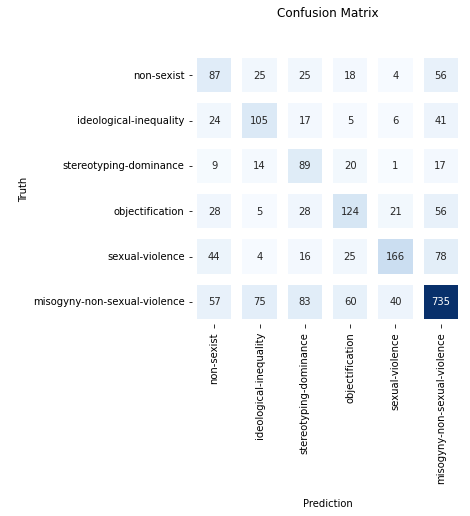

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred5_bool = np.argmax(y_pred5, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred5_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred5_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred5_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Bert Tokenization

In [ ]:
#tokenizer for Bert base model
from transformers import BertTokenizer
import tqdm
bert = 'bert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
bert_tokenizer = BertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def bert_tokenize(sentences, bert_tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = bert_tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        #print(inputs,'end of inputs')
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids']) 
        #print(inputs,'end of inputs')       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
#example testing
inputs = bert_tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')
ids,masks,segments = bert_tokenize("The capital of France is [MASK].", bert_tokenizer)
print(ids)
print(masks)
print(bert_tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['[CLS]', 'the', 'capital', 'o

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#task2
x_train2_int = [bert_tokenize(x_train2[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_train2)]
x_train2_mask = [bert_tokenize(x_train2[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_train2)]

x_val2_int = [bert_tokenize(x_val2[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_val2)]
x_val2_mask = [bert_tokenize(x_val2[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_val2)]

x_test2_int = [bert_tokenize(x_test[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_test)]
x_test2_mask = [bert_tokenize(x_test[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_test)]

x_train2_int_np = np.array(x_train2_int)
x_train2_mask_np = np.array(x_train2_mask)
x_val2_int_np = np.array(x_val2_int)
x_val2_mask_np = np.array(x_val2_mask)
x_test2_int_np = np.array(x_test2_int)
x_test2_mask_np = np.array(x_test2_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model6 - BERT Sequence Classification

In [ ]:
from transformers import TFBertForSequenceClassification, BertConfig
import tensorflow as tf

bert = 'bert-base-uncased'
config = BertConfig(num_labels=6)
config.output_hidden_states = False

def create_BertForSequenceClassification():
  transformer_model = TFBertForSequenceClassification.from_pretrained(bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model6 = create_BertForSequenceClassification()
    optimizer6 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model6.compile(optimizer=optimizer6, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model6 = create_BertForSequenceClassification()
  model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109486854  ['input_token[0][0]',            
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'masked_token[0][0]']           
 fication)                      logits=(None, 6),                                                 
                                 hidden_states=None                                         

Epoch 1/10
344/344 [==============================] - 121s 93ms/step - loss: 4.9035 - accuracy: 0.0786 - val_loss: 5.4586 - val_accuracy: 0.0640
Epoch 2/10
344/344 [==============================] - 25s 74ms/step - loss: 7.8091 - accuracy: 0.0764 - val_loss: 6.3174 - val_accuracy: 0.0785
Epoch 3/10
344/344 [==============================] - 26s 75ms/step - loss: 7.5334 - accuracy: 0.1044 - val_loss: 10.5362 - val_accuracy: 0.1206
Epoch 4/10
344/344 [==============================] - 26s 76ms/step - loss: 6.9964 - accuracy: 0.0975 - val_loss: 11.2285 - val_accuracy: 0.0625
Epoch 5/10
344/344 [==============================] - 26s 75ms/step - loss: 8.4831 - accuracy: 0.0910 - val_loss: 9.6818 - val_accuracy: 0.1206
Epoch 6/10
344/344 [==============================] - 26s 74ms/step - loss: 7.6797 - accuracy: 0.1070 - val_loss: 10.9640 - val_accuracy: 0.1206
Epoch 7/10
344/344 [==============================] - 26s 75ms/step - loss: 9.2329 - accuracy: 0.1088 - val_loss: 11.1749 - val_accu

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0625    0.0140    0.0228       215
           1     0.0000    0.0000    0.0000       198
           2     0.0000    0.0000    0.0000       150
           3     0.0000    0.0000    0.0000       262
           4     0.1495    0.9700    0.2591       333
           5     0.0000    0.0000    0.0000      1050

    accuracy                         0.1476      2208
   macro avg     0.0353    0.1640    0.0470      2208
weighted avg     0.0286    0.1476    0.0413      2208



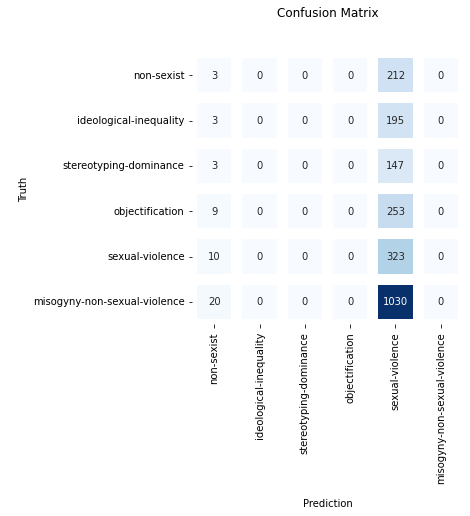

In [ ]:
history = model6.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

y_pred6 = model6.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

from sklearn.metrics import classification_report, accuracy_score
y_pred6_bool = np.argmax(y_pred6.logits, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred6_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred6_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred6_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model7 - BERT + NBOW

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFBertModel, BertConfig

def get_BERT_layer():
  bert = 'bert-base-uncased'
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFBertModel.from_pretrained(bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=50
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(6,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model7_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model7 = create_bag_of_words_BERT()
    optimizer7 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model7.compile(optimizer=optimizer7, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model7 = create_bag_of_words_BERT()
  model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model7.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model7_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:
history = model7.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 76s 60ms/step - loss: 1.1886 - accuracy: 0.5862 - val_loss: 0.9546 - val_accuracy: 0.6424
Epoch 2/10
344/344 [==============================] - 18s 51ms/step - loss: 0.8737 - accuracy: 0.6812 - val_loss: 0.9049 - val_accuracy: 0.6584
Epoch 3/10
344/344 [==============================] - 17s 50ms/step - loss: 0.6731 - accuracy: 0.7697 - val_loss: 0.8873 - val_accuracy: 0.6701
Epoch 4/10
344/344 [==============================] - 17s 50ms/step - loss: 0.4931 - accuracy: 0.8453 - val_loss: 0.9441 - val_accuracy: 0.6599
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.3593 - accuracy: 0.8967 - val_loss: 0.9983 - val_accuracy: 0.6497
Epoch 6/10
344/344 [==============================] - 17s 50ms/step - loss: 0.2684 - accuracy: 0.9367 - val_loss: 1.0723 - val_accuracy: 0.6613
Epoch 7/10
344/344 [==============================] - 17s 50ms/step - loss: 0.2166 - accuracy: 0.9491 - val_loss: 1.0989 - val_accuracy:

              precision    recall  f1-score   support

           0     0.3750    0.3628    0.3688       215
           1     0.4330    0.5707    0.4924       198
           2     0.3237    0.5200    0.3990       150
           3     0.4751    0.3282    0.3883       262
           4     0.6280    0.5526    0.5879       333
           5     0.7256    0.7076    0.7165      1050

    accuracy                         0.5806      2208
   macro avg     0.4934    0.5070    0.4921      2208
weighted avg     0.5935    0.5806    0.5826      2208



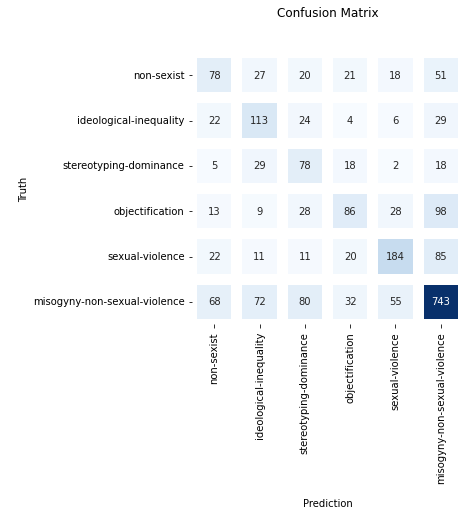

In [ ]:
y_pred7 = model7.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

from sklearn.metrics import classification_report, accuracy_score
y_pred7_bool = np.argmax(y_pred7, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred7_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred7_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred7_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model 8 - BERT + LSTM

In [ ]:
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def lstm():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  LSTM_sent=LSTM(100,name='LSTM')(embedded_sent)                             # LSTM
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(LSTM_sent)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  #label=Dense(3,input_shape=(EMBED_SIZE,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(LSTM_sent)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model8_LSTM')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model8 = lstm()
    optimizer8 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model8.compile(optimizer=optimizer8, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model8 = create_bag_of_words_BERT()
  model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model8.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model8_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:
history = model8.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 98s 76ms/step - loss: 1.3242 - accuracy: 0.5404 - val_loss: 1.1054 - val_accuracy: 0.5945
Epoch 2/10
344/344 [==============================] - 22s 63ms/step - loss: 1.0582 - accuracy: 0.5935 - val_loss: 1.0242 - val_accuracy: 0.6250
Epoch 3/10
344/344 [==============================] - 21s 62ms/step - loss: 0.9024 - accuracy: 0.6951 - val_loss: 0.9951 - val_accuracy: 0.6468
Epoch 4/10
344/344 [==============================] - 22s 63ms/step - loss: 0.7677 - accuracy: 0.7700 - val_loss: 0.9628 - val_accuracy: 0.6701
Epoch 5/10
344/344 [==============================] - 21s 62ms/step - loss: 0.6480 - accuracy: 0.8279 - val_loss: 1.0007 - val_accuracy: 0.6642
Epoch 6/10
344/344 [==============================] - 22s 63ms/step - loss: 0.5586 - accuracy: 0.8664 - val_loss: 1.0522 - val_accuracy: 0.6250
Epoch 7/10
344/344 [==============================] - 22s 63ms/step - loss: 0.4854 - accuracy: 0.8948 - val_loss: 1.0165 - val_accuracy:

              precision    recall  f1-score   support

           0     0.3609    0.2837    0.3177       215
           1     0.4905    0.5202    0.5049       198
           2     0.3591    0.5267    0.4270       150
           3     0.4508    0.5076    0.4776       262
           4     0.5584    0.6456    0.5989       333
           5     0.7707    0.6819    0.7236      1050

    accuracy                         0.5919      2208
   macro avg     0.4984    0.5276    0.5083      2208
weighted avg     0.6078    0.5919    0.5963      2208



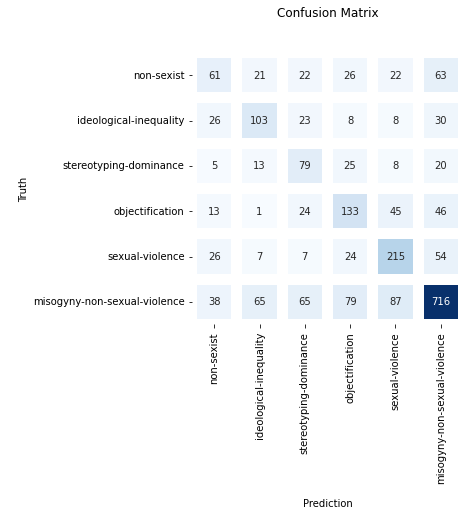

In [ ]:
y_pred8 = model8.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)
from sklearn.metrics import classification_report, accuracy_score
y_pred8_bool = np.argmax(y_pred8, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred8_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred8_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred8_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# NModel 9 - BERT + single CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFBertModel, BertConfig

def get_BERT_layer():
  bert = 'bert-base-uncased'
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFBertModel.from_pretrained(bert, config = config)


In [ ]:
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def cnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  CNN_sent=Conv1D(filters=100,
                 kernel_size=6,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1D')(embedded_sent)                             # CNN
  pooled_sent=GlobalMaxPooling1D(name='MaxPool')(CNN_sent)
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(pooled_sent)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model4_CNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model9 = cnn()
    optimizer9 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model9.compile(optimizer=optimizer9, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model9 = cnn()
  model9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model9.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model4_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_7 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                      

Epoch 1/10
344/344 [==============================] - 74s 62ms/step - loss: 1.2777 - accuracy: 0.5553 - val_loss: 1.0460 - val_accuracy: 0.6294
Epoch 2/10
344/344 [==============================] - 17s 50ms/step - loss: 0.9578 - accuracy: 0.6641 - val_loss: 0.9599 - val_accuracy: 0.6497
Epoch 3/10
344/344 [==============================] - 17s 51ms/step - loss: 0.7619 - accuracy: 0.7475 - val_loss: 0.9129 - val_accuracy: 0.6730
Epoch 4/10
344/344 [==============================] - 17s 50ms/step - loss: 0.5853 - accuracy: 0.8206 - val_loss: 0.9402 - val_accuracy: 0.6701
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.4261 - accuracy: 0.8792 - val_loss: 0.9913 - val_accuracy: 0.6730
Epoch 6/10
344/344 [==============================] - 17s 50ms/step - loss: 0.3188 - accuracy: 0.9207 - val_loss: 1.0039 - val_accuracy: 0.6599
Epoch 7/10
344/344 [==============================] - 17s 50ms/step - loss: 0.2472 - accuracy: 0.9472 - val_loss: 1.0585 - val_accuracy:

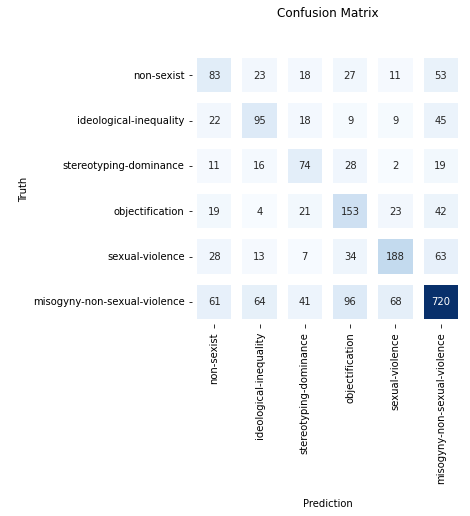

In [ ]:
history = model9.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

y_pred9 = model9.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

from sklearn.metrics import classification_report, accuracy_score
y_pred9_bool = np.argmax(y_pred9, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred9_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred9_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred9_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model10 - BERT + multi CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFBertModel, BertConfig

def get_BERT_layer():
  bert = 'bert-base-uncased'
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFBertModel.from_pretrained(bert, config = config)


In [ ]:
import tensorflow as tf
from keras.layers import Concatenate
EMBED_SIZE = 100
hidden_layer = 50

def multicnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  conv_blocks = []
  CNN_sent1=Conv1D(filters=100,
                 kernel_size=3,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1')(embedded_sent)                             # CNN1
  pooled_sent1=GlobalMaxPooling1D(name='MaxPool1')(CNN_sent1)  
  CNN_sent2=Conv1D(filters=100,
                 kernel_size=5,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN2')(embedded_sent)                             # CNN2
  pooled_sent2=GlobalMaxPooling1D(name='MaxPool2')(CNN_sent2)
  CNN_sent3=Conv1D(filters=100,
                 kernel_size=7,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN3')(embedded_sent)                             # CNN3
  pooled_sent3=GlobalMaxPooling1D(name='MaxPool3')(CNN_sent3)
  conv_blocks.append(pooled_sent1)
  conv_blocks.append(pooled_sent2)
  conv_blocks.append(pooled_sent3)

  #merge
  combined = Concatenate()(conv_blocks)

  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(combined)
  label=Dense(6,input_shape=(hidden_layer,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model10_BERT_multiCNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model10 = multicnn()
    optimizer10 = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model10.compile(optimizer=optimizer10, loss='categorical_crossentropy', metrics=['accuracy'])
else:
  model10 = multicnn()
  model10.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model10.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.89.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model10_BERT_multiCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_9 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                           

In [ ]:
history = model10.fit([x_train2_int_np,x_train2_mask_np],
                    y_train2,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val2_int_np,x_val2_mask_np], y_val2),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 76s 62ms/step - loss: 1.2710 - accuracy: 0.5488 - val_loss: 1.0069 - val_accuracy: 0.6337
Epoch 2/10
344/344 [==============================] - 17s 50ms/step - loss: 0.9423 - accuracy: 0.6536 - val_loss: 0.9542 - val_accuracy: 0.6773
Epoch 3/10
344/344 [==============================] - 17s 50ms/step - loss: 0.7192 - accuracy: 0.7566 - val_loss: 0.9429 - val_accuracy: 0.6628
Epoch 4/10
344/344 [==============================] - 18s 51ms/step - loss: 0.5059 - accuracy: 0.8486 - val_loss: 1.0492 - val_accuracy: 0.6221
Epoch 5/10
344/344 [==============================] - 18s 51ms/step - loss: 0.3736 - accuracy: 0.8905 - val_loss: 1.0191 - val_accuracy: 0.6642
Epoch 6/10
344/344 [==============================] - 18s 51ms/step - loss: 0.2781 - accuracy: 0.9250 - val_loss: 1.0660 - val_accuracy: 0.6599
Epoch 7/10
344/344 [==============================] - 18s 51ms/step - loss: 0.2122 - accuracy: 0.9429 - val_loss: 1.2612 - val_accuracy:

In [ ]:
y_pred10 = model10.predict([x_test2_int_np,x_test2_mask_np],batch_size=512)

              precision    recall  f1-score   support

           0     0.3889    0.4558    0.4197       215
           1     0.4426    0.4091    0.4252       198
           2     0.5385    0.1867    0.2772       150
           3     0.4435    0.3893    0.4146       262
           4     0.5521    0.5405    0.5463       333
           5     0.6807    0.7552    0.7160      1050

    accuracy                         0.5806      2208
   macro avg     0.5077    0.4561    0.4665      2208
weighted avg     0.5737    0.5806    0.5699      2208



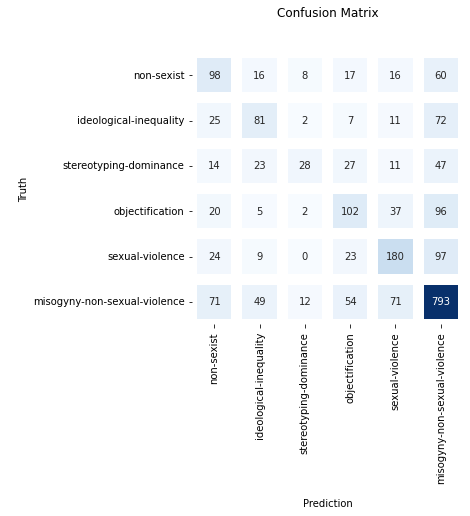

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred10_bool = np.argmax(y_pred10, axis=1)
print(classification_report(np.argmax(y_test2, axis=1), y_pred10_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred10_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(np.argmax(y_test2, axis=1), y_pred10_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'], yticklabels=['non-sexist','ideological-inequality','stereotyping-dominance','objectification', 'sexual-violence', 'misogyny-non-sexual-violence'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');